# Quick Dash score
to assess whethere movement quality is related to patient reported functioning. 
We expect that movement quality post-operatively is related to patient reported disability and pain scores. 
And that there are differences in movement quality between the people with a DASH < 15 and those above 15. The threshold of 15 is chosen because this indicates whether someome is 'disabled' or not

1) Only retain t1 (1 months post-op data) 
and remove participants with to many NaN

2) Calculate the total DASH score

Berekening Quick DASH beperkingen en symptomen score:  
{(Som van de antwoorden op N items / N ) – 1} x 25 
N = aantal ingevulde antwoorden  
Let op: de Quick DASH score mag niet berekend worden als meer dan 1 vraag niet beantwoord is.


3) Split group on disabled group and non-disabled

4) Correlate the Quick Dash scores with movement quality. i.e. do people with a higher score perform better?


In [1]:
import numpy as np
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

#### Input data sets
1) Dash scores

In [2]:
raw = pd.read_csv("C:\\Users\\u0117545\\KU Leuven\\An De Groef - DATA\\XsensTest\\QuickDASH\\UPLIFTBC-QuickDASH_DATA_2022-10-31_1406 (1).csv",
                   sep=';')

In [3]:
# only retain T1 of the dash scores 
idx = raw['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
raw = raw.iloc[mask]
raw.head()

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
1,BC_001,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,BC_002,t1_1_month_postsur_arm_1,2.0,3.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0
6,BC_003,t1_1_month_postsur_arm_1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0
9,BC_005,t1_1_month_postsur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0
11,BC_006,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
# remove participants with more than 2 NaNs
# Remove rows with missing values
print("Before removing rows with missing data: {} rows".format(len(raw)))
df_dash = raw.dropna(thresh=raw.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

Before removing rows with missing data: 21 rows
After removing rows with missing data: 15 rows


2) Movement quality parameters

In [5]:
df_qual = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/Output/MoveQual_aff.xlsx', sheet_name = 'T1')
df_qual.head()

,ppID,trial,time,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,...,reg_z,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A
0,BC_001,F_R_001,T1,3.909115,1.957181,2.077710,3.944575,0.259029,0.785658,0.171573,...,0.369042,0.334084,0.798958,0.472604,1.267990,1.699086,0.508418,0.300742,0.806887,-7.967747
1,BC_002,F_L_001,T1,4.458713,2.719153,2.621305,1.984547,0.902005,1.033625,0.815747,...,0.632253,0.476648,1.683983,1.310636,2.326022,3.344825,0.533485,0.415209,0.736882,-7.350596
2,BC_003,F_R_001,T1,2.229362,1.361607,2.293970,2.628487,0.590969,1.491857,0.410060,...,0.846187,0.668993,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.751294
3,BC_005,F_R_001,T1,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,...,0.852151,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945
4,BC_006,F_R_001,T1,4.234773,1.946619,1.694642,3.916913,1.015030,1.453888,0.623353,...,0.704855,0.600082,2.442922,1.237454,3.456272,4.740709,0.553995,0.280624,0.783798,-7.253921


#### Calculate total dash scores

In [6]:
som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))



Average score over all participants and timepoints = 26.363636363636363
Maximum and minumum scores are 70.45454545454545 & 0.0 respectively


In [7]:
#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

In [8]:
# merge the dataframes on ppID remove time and trial (since it is all 1 months post op)
# use df for all furhter analysis
df = df_totaldash.merge(df_qual)
df = df.drop(labels=['trial', 'time'], axis = 1)
df.head()

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,reg_z,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A
0,BC_001,0.000000,3.909115,1.957181,2.077710,3.944575,0.259029,0.785658,0.171573,0.259417,...,0.369042,0.334084,0.798958,0.472604,1.267990,1.699086,0.508418,0.300742,0.806887,-7.967747
1,BC_002,20.454545,4.458713,2.719153,2.621305,1.984547,0.902005,1.033625,0.815747,0.963327,...,0.632253,0.476648,1.683983,1.310636,2.326022,3.344825,0.533485,0.415209,0.736882,-7.350596
2,BC_003,15.909091,2.229362,1.361607,2.293970,2.628487,0.590969,1.491857,0.410060,0.517819,...,0.846187,0.668993,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.751294
3,BC_005,29.545455,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,0.882556,...,0.852151,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945
4,BC_006,0.000000,4.234773,1.946619,1.694642,3.916913,1.015030,1.453888,0.623353,0.749304,...,0.704855,0.600082,2.442922,1.237454,3.456272,4.740709,0.553995,0.280624,0.783798,-7.253921


#### 3) Split group on disabled group and non-disabled

In [9]:
# find the people with a dash score higher than 15
idx = df['total_score'] > 15
mask = np.where(idx)[0]
pain = df.iloc[mask]
pain['group'] = 'pain'

# find the people with a dash score lower than 15
idx = df['total_score'] <= 15
mask = np.where(idx)[0]
no_pain = df.iloc[mask]
no_pain['group'] = 'no_pain'

print('number of people with perceived disablity: {}'.format(len(pain)))
print('number of people with no perceived disablity: {}'.format(len(no_pain)))

number of people with perceived disablity: 9
number of people with no perceived disablity: 6


C:\Users\u0117545\AppData\Local\Temp/ipykernel_18012/2431622730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pain['group'] = 'pain'
C:\Users\u0117545\AppData\Local\Temp/ipykernel_18012/2431622730.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_pain['group'] = 'no_pain'


In [10]:
df2 = pd.concat([pain, no_pain], axis=0, ignore_index=True)
df2

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A,group
0,BC_002,20.454545,4.458713,2.719153,2.621305,1.984547,0.902005,1.033625,0.815747,0.963327,...,0.476648,1.683983,1.310636,2.326022,3.344825,0.533485,0.415209,0.736882,-7.350596,pain
1,BC_003,15.909091,2.229362,1.361607,2.293970,2.628487,0.590969,1.491857,0.410060,0.517819,...,0.668993,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.751294,pain
2,BC_005,29.545455,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,0.882556,...,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945,pain
3,BC_007,52.272727,2.346777,1.227715,3.071512,1.725340,0.902467,1.101804,0.662207,0.993165,...,0.663705,2.381153,1.611861,3.200631,4.541092,0.553427,0.374628,0.743890,-6.522885,pain
4,BC_010,65.909091,2.872189,1.774267,3.280430,3.615102,0.983898,0.733107,0.659098,0.869107,...,0.670751,2.281761,2.878135,3.792345,5.595719,0.432202,0.545164,0.718330,-6.564558,pain
5,BC_014,31.818182,2.729024,0.752086,3.010122,1.666390,0.785474,0.641934,0.385323,0.806548,...,0.427720,2.028491,1.529089,3.013442,4.196783,0.514678,0.387967,0.764584,-6.820294,pain
6,BC_015,59.090909,3.333666,3.326168,2.694549,2.280530,1.017540,1.151159,0.707833,1.090691,...,0.658816,3.032299,1.909733,4.262346,5.890270,0.544533,0.342946,0.765423,-6.137404,pain
7,BC_020,70.454545,3.217877,1.551900,3.367898,2.956202,0.710237,0.747793,0.486494,0.768336,...,0.485994,1.988422,1.791405,2.848364,4.248759,0.508747,0.458339,0.728767,-6.730655,pain
8,BC_021,20.454545,2.935130,0.779476,3.331758,0.617708,0.729253,0.520083,0.439338,0.810753,...,0.366516,2.241538,0.967412,3.125108,4.145709,0.565233,0.243946,0.788037,-6.931006,pain
9,BC_001,0.000000,3.909115,1.957181,2.077710,3.944575,0.259029,0.785658,0.171573,0.259417,...,0.334084,0.798958,0.472604,1.267990,1.699086,0.508418,0.300742,0.806887,-7.967747,no_pain


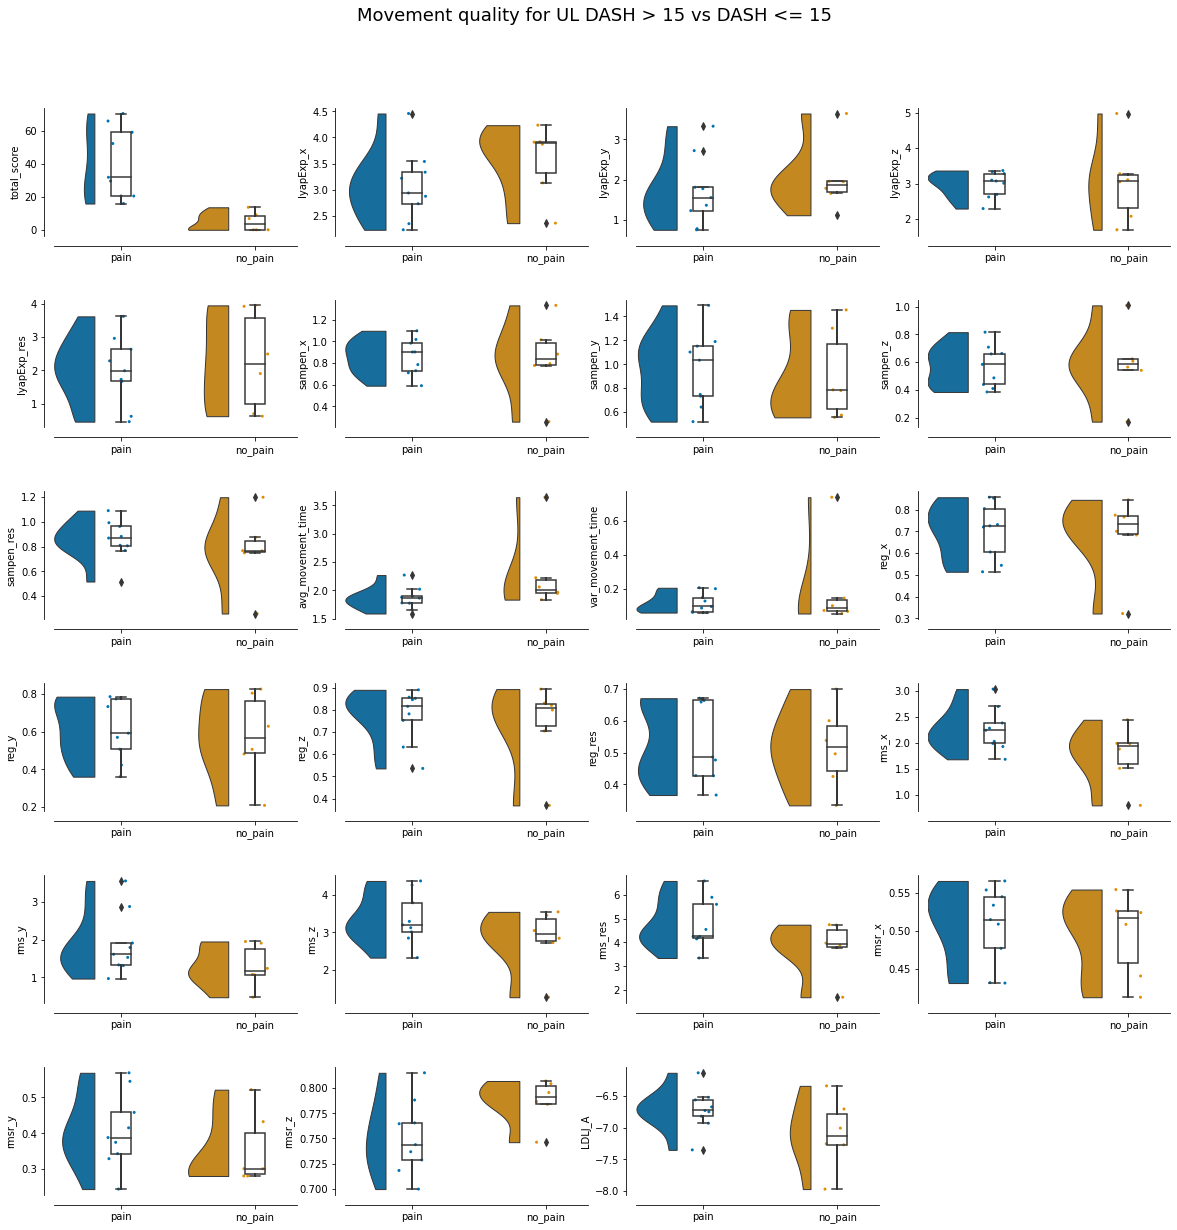

In [11]:
# plot the results
X = df2.drop(['ppID', 'group'], axis = 1)
# find minimium required rows given we want 5 columns
ncols = 4
nrows = len(X.columns) // ncols + (len(X.columns) % ncols > 0)
dx = "group"; ort = "v"; pal = 'colorblind'; sigma = .6; viol = .6; mv = .0

f = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Movement quality for UL DASH > 15 vs DASH <= 15", fontsize=18, y=0.95)

f.tight_layout();
offset = 0.1;

for n, columns in enumerate(X.columns):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)
    
    # filter df and plot ticker on the new subplot axis
    #df[df["ticker"] == ticker].plot(ax=ax)
     
    pt.RainCloud(x = dx, y = columns, data = df2, ax = ax,
                palette = pal, bw = sigma, width_viol = viol,
                orient = ort, move = mv)
    sns.despine(offset=10)
    ax.set_xlabel('')

In [12]:
for var in df2.columns:
    print('Analyzing {}'.format(var))
    if var == 'ppID' or var == 'group':
        print(80 * '_' + '\n')
    else:
        t_statistic, pvalue = stats.mannwhitneyu(pain[var], no_pain[var])
        print(t_statistic, round(pvalue, ndigits=4))
        
        print(80* "_" + "\n" )
        

Analyzing ppID
________________________________________________________________________________

Analyzing total_score
54.0 0.0017
________________________________________________________________________________

Analyzing lyapExp_x
15.0 0.181
________________________________________________________________________________

Analyzing lyapExp_y
18.0 0.3277
________________________________________________________________________________

Analyzing lyapExp_z
29.0 0.8639
________________________________________________________________________________

Analyzing lyapExp_res
22.0 0.607
________________________________________________________________________________

Analyzing sampen_x
27.0 1.0
________________________________________________________________________________

Analyzing sampen_y
28.0 0.9546
________________________________________________________________________________

Analyzing sampen_z
27.0 1.0
________________________________________________________________________________